# Clustering Sura 1, Aya 1
Version: 11.03.2025  
by: Thomas Jurczyk  

This notebook includes:

1. An overview and exploratory data analysis of the subchapter data that should be clustered.
2. The retrieval of document embeddings for each subchapter.
3. Clustering of the documents using the retrieved embeddings.

In [40]:
# imports
import os
import matplotlib.pyplot as plt
import re
import pandas as pd

# Apply a style
plt.style.use('ggplot')

## Data
The data consists of subchapters from the A01 tafsir corpus that include a discussion of the first aya of the first sura. Note that some chapters do not only discuss the first aya but are subchapters discussing multiple ayat.

### Tokens per subchapter
Next, we count the number of tokens in each subchapter and compare the results with each other. A token is simply defined by at least one blank space separating the tokens. The tokens are not cleaned of non-Arabic characters and still include punctuation marks as well (these might in some cases count as separate tokens as well due to the way the data was collected and reconstructed).

In [61]:
token_counter = dict()
for filename in os.listdir("data"):
    with open(f"data/{filename}", "r", encoding="utf-8") as f:
        text = f.read()
        tokens = re.split(r"\s+", text)
        token_counter[filename[:-4]] = len(tokens)

In [62]:
df = pd.DataFrame.from_dict(token_counter, orient="index").reset_index()

In [63]:
df.columns = ["id", "token_count"]

In [64]:
df.describe()

,token_count
count,71.000000
mean,3535.126761
std,5998.105189
min,12.000000
25%,444.500000
50%,1280.000000
75%,3670.500000
max,32814.000000


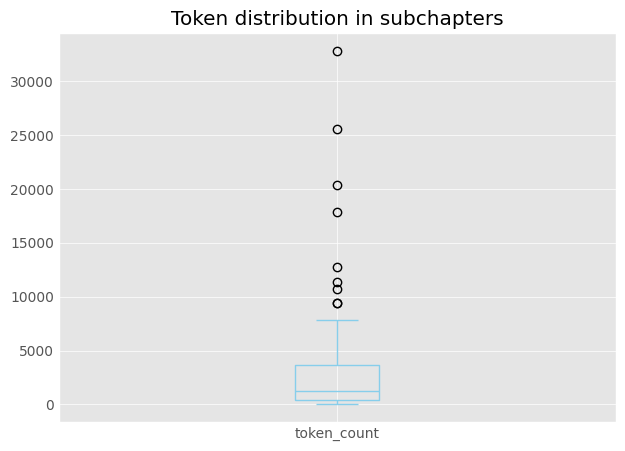

In [89]:
df["token_count"].plot(kind="box", title="Token distribution in subchapters", color="skyblue")

plt.savefig("images/boxplot.jpg")

In [68]:
# show outliers
df.sort_values("token_count")

,id,token_count
69,sc.105_1_1_1,12
68,sc.47_1_1_1,24
62,sc.71_1_1_1,32
57,sc.8_1_1_2,68
70,sc.67_1_1_4,82
...,...,...
65,sc.97_1_1_7,12800
47,sc.49_1_1_7,17902
44,sc.103_1_1_7,20356
14,sc.22_1_1_7,25596


### Comparison of one aya vs. multi ayat subchapters

In [70]:
# First, we annotate the subchapters as multi ayat (1) or single ayat (0)

In [81]:
df["multi_ayat"] = df["id"].map(lambda x: "multi_ayat" if x.split("_")[-1] != "1" else "single_aya")

In [82]:
# Creating stats for both subsets

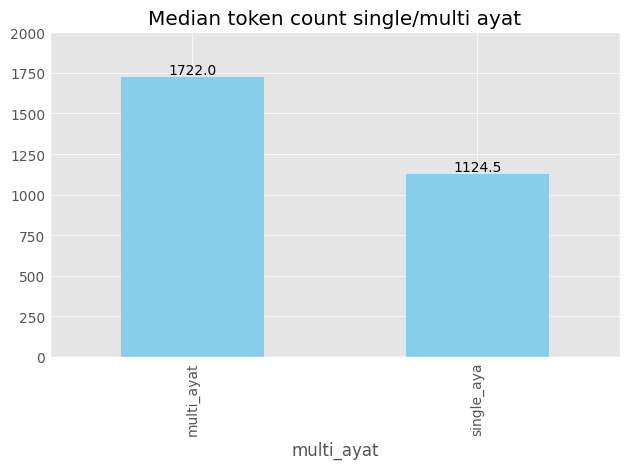

In [98]:
ax = df.groupby("multi_ayat")["token_count"].median().plot(kind="bar", title="Median token count single/multi ayat", color="skyblue")
# Display count on top of each bar
for bar in ax.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.ylim(0,2000)

plt.tight_layout()

plt.savefig("images/median_mayat.jpg")

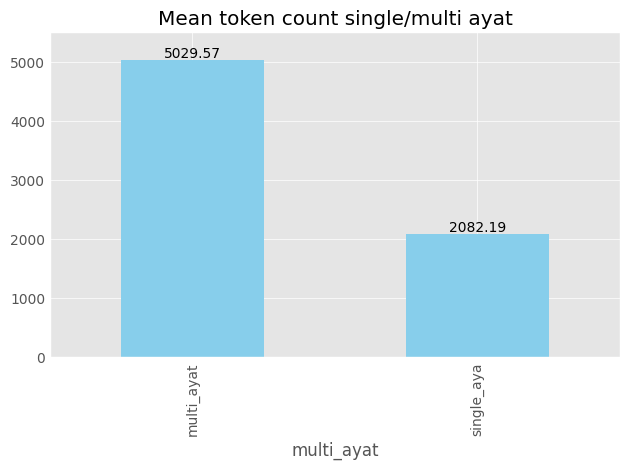

In [101]:
ax = df.groupby("multi_ayat")["token_count"].mean().plot(kind="bar", title="Mean token count single/multi ayat", color="skyblue")
# Display count on top of each bar
for bar in ax.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.ylim(0,5500)

plt.tight_layout()

plt.savefig("images/mean_mayat.jpg")

### Ayat discussed in the subchapters
The following diagram and dictionary demonstrates how often the firrst ayat from the first sura are discussed in the subchapter corpus.

In [31]:
ayat_counter = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0
}

for filename in os.listdir("data"):
    tmp_ls = filename.split("_")[-2:]
    tmp_ls[1] = tmp_ls[1].split(".")[0]
    tmp_ls[0], tmp_ls[1] = int(tmp_ls[0]), int(tmp_ls[1])
    # Increasing ayat counter
    for i in range(tmp_ls[0], tmp_ls[1]+1):
        ayat_counter[i] += 1

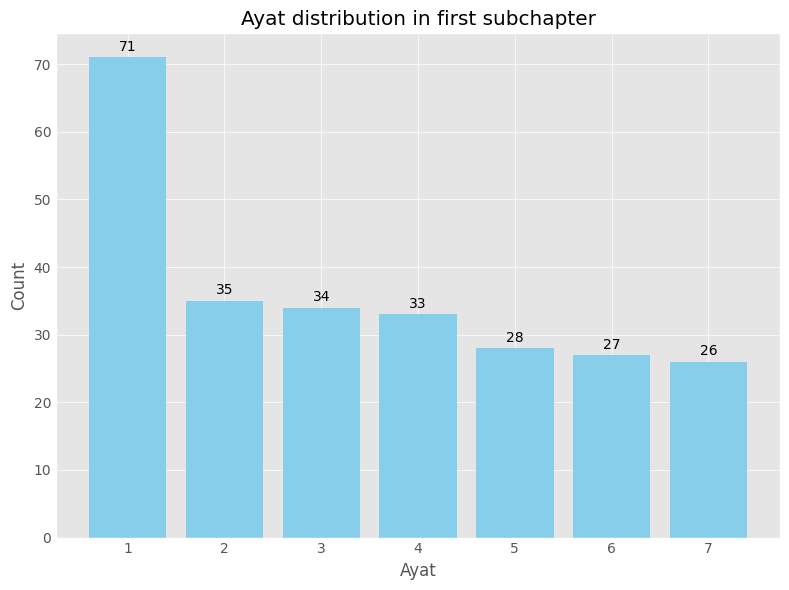

In [34]:
# Extract keys and values
categories = list(ayat_counter.keys())
values = list(ayat_counter.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color='skyblue')

# Display count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Add title and labels
plt.title('Ayat distribution in first subchapter')
plt.xlabel('Ayat')
plt.ylabel('Count')

# Tight layout
plt.tight_layout()

# Save plot
plt.savefig("images/subchapters.jpg")

## Embeddings
In a first step, we are acquiring the embeddings using Mistral's `mistral-embed` model.